## LAB: La maldición de la dimensionalidad

Para entender el efecto de la cantidad de dimensiones en la capacidad predictiva del modelo vamos a trabajar en un clasificador de noticias de dos diarios argentinos para intentar distinguir entre uno y otro a partir del vocabulario que utilizan. <br />

Para esto vamos a implementar un modelo de tipo Naïve Bayes con vectorización de tipo TF-IDF.

In [1]:
import pandas as pd
df_clarin = pd.read_csv('../Data/clarin.csv')
df_clarin['class'] = 0

In [2]:
df_p12 = pd.read_csv('../Data/pagina12.csv')
df_p12['class'] = 1

In [3]:
df = pd.concat([df_clarin,df_p12])

In [4]:
df.sample(5)

,Unnamed: 0,cuerpo,fecha_hora,imagen,resumen,suplemento,titulo,url,class
339,339,AriesSigue la energía del Plenilunio operan...,09/10/2017,//images.clarin.com/2017/10/09/Hk3k3eFnW_930x5...,El ingreso de Júpiter a Escorpio es uno de los...,/entremujeres/,Horóscopo semanal: Júpiter ingresa a Escorpio ...,http://www.clarin.com/entremujeres/astrologia/...,0
144,144,"Buenos Aires, 6 de outubro de 2017​As manche...",06/10/2017,//images.clarin.com/2017/10/06/By5EikH2Z_930x5...,"Partida no estádio da Bombonera, no bairro da ...",/br/,Argentina x Peru: empate com gosto de derrota,http://www.clarin.com/clarin-em-portugues/dest...,0
92,92,En día anterior al comienzo Congreso Tecnoló...,10/10/2017,//images.clarin.com/2017/10/09/HyM6c_Y2b_930x5...,Con un nutrido público de chicos que tienen en...,/rural/,Los jóvenes ya están reunidos en la previa del...,http://www.clarin.com/rural/jovenes-reunidos-p...,0
309,309,"Debido a su enfermedad (fibromialgia, que le...",07/10/2017,//images.clarin.com/2017/09/18/H15WriAqb_930x5...,La cantante subió un video a Instagram donde d...,/espectaculos/musica/,Lady Gaga defendió a una nena contra el bullying,http://www.clarin.com/espectaculos/fama/lady-g...,0
15,15,"Juan Grabois, el dirigente social amigo del ...",10/10/2017,//images.clarin.com/2016/11/02/HJL971QLW_930x5...,Juan Grabois acusó a la fuerza de seguridad de...,/politica/,"Para un amigo del Papa Francisco, ""no hay cart...",http://www.clarin.com/politica/amigo-papa-fran...,0


### 1. Limpieza

#### 1.1 Faltantes

A partir del dataset observamos que los campos que probablemente contengan el vocabulario relevante son "cuerpo", "título" y "resumen".
Sacar del análisis los registros que no tienen cuerpo o título disponible y completar los resúmenes faltantes con una campo en blanco


In [5]:
df = df[df['cuerpo'].notnull()].copy()

In [6]:
df = df[df['titulo'].notnull()].copy()

In [7]:
df['resumen'].fillna('',inplace=True)

#### 1.2 Suplementos relevantes

Para mejorar la clasificación es conveniente retirar las secciones donde los dos diarios utilizan un vocabulario similar y muy específico del dominio como, por ejemplo, las relacionadas a deportes.

In [8]:
# Filtramos las noticias relacionadas a deportes
df = df[df['suplemento'].str.lower().str.contains('deportes')==False].copy()

In [9]:
df['suplemento'].value_counts()

El país                  65
Sociedad                 24
El mundo                 17
Economía                 17
/espectaculos/fama/      10
/espectaculos/           10
/espectaculos/musica/    10
/espectaculos/teatro/    10
/ciudades/               10
/arq/                    10
/buena-vida/             10
/br/                     10
/revista-enie/           10
/autos/                  10
/politica/               10
/entremujeres/           10
/rural/                  10
/cultura/                10
/sociedad/               10
/lo-ultimo/              10
/espectaculos/tv/        10
/policiales/             10
/viva/                   10
/viajes/                 10
/opinion/                10
/espectaculos/cine/      10
/economia/               10
/cartas_al_pais/         10
/tecnologia/              9
/mundo/                   8
Universidad               5
Plástica                  4
Contratapa                2
/si/                      1
Name: suplemento, dtype: int64

#### 1.3 Corpus

Construir la columna sobre la cual vamos a predecir concatenando el título, resumen y cuerpo de las distintas noticias.

In [10]:
df['full'] = df['cuerpo'].astype('str') + df['titulo'] + df['resumen']

#### 1.4 Normalización del texto

Primero es conveniente pasar todo el corpus a letras minúsculas.

Para mejorar el clasificador es importante sacar todos los acentos que pueden generar diferencias artificiales entre palabras según estén o no puestos. Hint: Utilizar el módulo unidecode

Una vez retirados los acentos, quitar todos los signos de puntuación para dejar únicamente palabras. Hint: utilizar una expresión regular, por ejemplo, r'([^\s\w]|_)+' para reemplazar todo lo que no sean palabras.

In [11]:
df['full'] = df['full'].str.lower()

In [12]:
from unidecode import unidecode
df['full'] = df['full'].apply(unidecode)

In [13]:
df['full'].sample(3)

74     desde corrientes\nal cierre de esta edicion, l...
88     paginai12 en bolivia\ndesde cochabamba\nhoy co...
143      buenos aires, 06 de outubro de 2017 hoje, o ...
Name: full, dtype: object

In [14]:
import re
df['full'] = df['full'].apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

In [15]:
df['full'].sample(3)

91     las ideas prefabricadas son interesantes por a...
99     la salud para todos ya no es un objetivo para ...
149    ayer comenzo la inscripcion en linea para el i...
Name: full, dtype: object

## 2. Modelo

Vectorizar el corpus resultante con TF-IDF y aplicar un modelo Naive Bayes con un split simple entre train y test. 
<br />
¿Cuál es la dimensión de la matriz de features? ¿Cuál es el accuracy obtenido? <br />
Dibujar la matriz de confusión.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['full'], df['class'], test_size=0.33, random_state=42) 

In [17]:
# Sólo para chequear el tamaño de la matriz de features
from sklearn.feature_extraction.text import TfidfVectorizer
m1 = TfidfVectorizer()
X_train_vec = m1.fit_transform(X_train)
X_train_vec.shape

(262, 22587)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [19]:
model.fit(X_train, y_train)
labels = model.predict(X_test)

In [20]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, labels)

0.6923076923076923

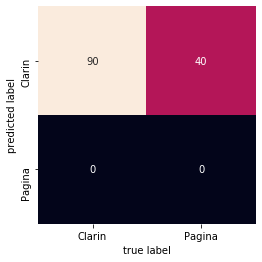

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns;
import matplotlib.pyplot as plt
%matplotlib inline
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Clarin','Pagina'], yticklabels=['Clarin','Pagina'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## 3. Reducción de la dimensionalidad

¿Cuál es la relación entre la cantidad de features y la cantidad de casos de entrenamiento? De acuerdo a la maldición de la dimensionalidad esta relación es un problema.<br/>
Una de las técnicas más comunes para reducir dimensiones es utilizar "stopwords", una lista con las palabras de cada idioma que no tienen un peso semántico importante. <br />
Entrenen nuevamente el modelo quitando las stopwords del español que se encuentran en el archivo "stopwords.csv". <br />
¿Qué pasa con la cantidad de dimensiones de la matriz de features? ¿Y con el accuracy?

In [23]:
stopwords = pd.read_csv('../Data/stopwords.csv',header=None)[0]

In [24]:
from unidecode import unidecode
stopwords = stopwords.apply(unidecode) 

In [25]:
# Es importante que las stopwords se encuentren en una lista
stopwords = list(stopwords)

In [26]:
# Sólo para chequear el tamaño de la matriz de features
m1 = TfidfVectorizer(stop_words = list(stopwords))
X_train_vec = m1.fit_transform(X_train)
X_train_vec.shape

(262, 22385)

In [27]:
model = make_pipeline(TfidfVectorizer(stop_words = list(stopwords)), MultinomialNB())

In [28]:
model.fit(X_train, y_train)
labels = model.predict(X_test)

In [29]:
accuracy_score(y_test, labels)

0.7615384615384615

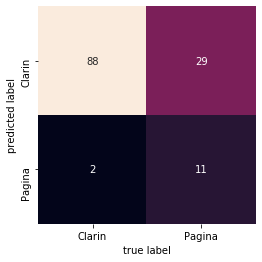

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns;
import matplotlib.pyplot as plt
%matplotlib inline
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Clarin','Pagina'], yticklabels=['Clarin','Pagina'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## 4. Avanzando en la reducción de dimensiones

El modelo mejora cuando quitamos las stopwords pero todavía tenemos una cantidad de dimensiones demasiado alta para 
la cantidad de datos que tenemos.

Pensemos lo siguiente ¿Qué valor tienen las palabras que aparecen una o dos veces en todo el corpus a la hora de discriminar? Para remover del análisis las palabras que ocurren menos de determinada cantidad de veces, la clase TfidfVectorizer tiene un parámetro min_df. 

Prueben setear el parámetro min_df en 6 y volver a correr el modelo.
<br />
<strong>
¿A cuánto se reduce la dimensión de la matriz de features?
<br />
¿Cuánto mejora la performance del algoritmo?
<strong />

In [31]:
model = make_pipeline(TfidfVectorizer(stop_words = list(stopwords), min_df=6), MultinomialNB())

In [32]:
model.fit(X_train, y_train)
labels = model.predict(X_test)

In [33]:
model_vec2 = TfidfVectorizer(stop_words = list(stopwords), min_df=10)

In [34]:
X_train_vec = model_vec2.fit_transform(X_train)

In [35]:
X_train_vec.shape

(262, 1206)

In [36]:
accuracy_score(y_test, labels)

0.8461538461538461

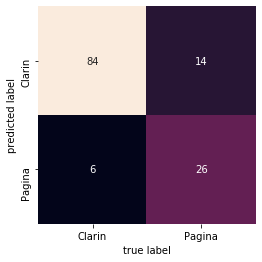

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns;
import matplotlib.pyplot as plt
%matplotlib inline
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Clarin','Pagina'], yticklabels=['Clarin','Pagina'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [38]:
pred = model.predict(['La candidata a senadora de Unidad Ciudadana dijo que la decisión de la Sala II de la Cámara Federal porteña ordenar la detención de Julio De Vido es parte de la campaña impulsada por el macrismo. En una entrevista con Telefe cuestionó también al Gobierno por la defensa de la Gendarmería frente a la desaparición de Santiago Maldonado.'])
print('Clarin' if pred[0] == 0 else 'Página 12')

Página 12


In [39]:
pred = model.predict(['La Cámara exigió la detención de De Vido por su influencia para destruir pruebas '])
print('Clarin' if pred[0] == 0 else 'Página 12')

Clarin
